
# What is survival analysis, and when do you need it?

Program for this talk:

1. What is right-censored time-to-event data and why naive regression models fail on
   such data?
2. Modeling
   - 2.1 Unconditional survival analysis with Kaplan Meier
   - 2.2 Conditional survival analysis with Cox Proportional Hazards, a log-linear
     estimator
   - 2.3 Conditional survival analysis and competing risk with SurvivalBoost, a non
     linear boosting tree method.
3. Use-cases and limitations
---



## 1. What is right-censored time-to-event data?

### 1.1 Censoring

Survival analysis is a **time-to-event regression** problem, with censored data. We
call censored all individuals that didn't experience the event during the range of the
observation window.

In our setting, we're mostly interested in right-censored data, meaning we that the
event of interest did not occur before the end of the observation period (typically
the time of collection of the dataset):

<figure>
<img src="assets/censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or
may not be ended by the time of observation.

Survival analysis techniques have wide applications:

- In the **medical** landscape, events can consist in patients dying of cancer, or on
  the contrary recovering from some disease.
- In **predictive maintenance**, events can consist in machine failures.
- In **insurance**, we are interesting in modeling the time to next claim for a
  portfolio of insurance contracts.
- In **marketing**, we can consider a user churning as an event, or we could focus on
  users becoming premium (members that choose to pay a subscription after having used
  the free version of a service for a while).

Answering questions like:
- What is the probability that a new user churn in 6 months? 1 year? 5 years?
- How long does it take for this user to churn with a probability of 50%?

As we will see, for all those applications, it is not possible to directly train a
machine learning-based regression model on such a **right-censored** time-to-event
target since we only have a lower bound on the true time to event for some data
points. **Naively removing such points from the dataset would cause the model
predictions to be biased**.



## 1.2 Our Tasks

Some notations:

We denote the observed time-to-event $T = \min(T^*, C)$, where:
- $T^* \in \mathbb{R}_+$ is the event time for an hypothetical unlimited observation
  window.
- $C \in \mathbb{R}_+$ is the censoring time

In summary, we can observe $(\bold{X},T,\Delta) \sim D$, where:
- $\bold{X} \sim \mathcal{X}$ are our covariates: information about the
  individuals at the time of making the prediction.
- $T = \min(T^*, C)$ with $T \in \mathbb{R}_+$, the censored time-to-event.
- $\Delta = T^* < C$ with $ \Delta \in [0, 1]$, the event indicator, 0 is a
  censored observation.

We sometimes assemble all the observable information related to the target as
the joint $Y = (T, \Delta)$.

However, we are primarily interested in the conditional distribution $T^*|\bold{X}$.

Our main quantities of interest to estimate are:

- **The Survival Function** represents the probability that an event doesn't occur at
  or before some given time $t$:

$$S^*(t|\bold{x})=P(T^*>t|\bold{X=x})$$

- **The Cumulative Incidence Function** is the inverse of the survival function, and
  represents the probability that an event occur before some given time $t$:

$$F^*(t|\bold{x}) = 1 - S^*(t|\bold{x}) = P(T^*\leq t|\bold{X=x})$$


### 1.3 Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of
two elements:

- The event indicator $\delta_i\in\{0, 1\}$, where $0$ marks censoring and $1$ is
  indicative that the event of interest has actually happened before reaching
  the end of the observation window.
- The censored time-to-event $t_i=\min(t^*_{i}, c_i) > 0$, that is the
  minimum between the date of the hypothetical event $t^*_i$ and the censoring
  date $c_i$. In a real-world setting, we don't have direct access to $t^*_i$
  when $\delta_i=0$. We can only record $t_i$.

We define the compound target $y_i = (t_i, \delta_i)$ as a tuple of the two
observables for each individual.

Here is how we represent our target for a synthetic predictive maintenance
dataset of 10,000 observations collected by the operator of a fleet of
trucks:

In [1]:
from sklearn.datasets import fetch_file
import pandas as pd

DATA_URL = "https://github.com/probabl-ai/survival-analysis-tutorial/releases/download/data-2025-05-19/"
file_url = DATA_URL + "truck_failure_10k_any_event.parquet"
y = pd.read_parquet(fetch_file(file_url, folder="truck_dataset"))
y.round(1)

,event,duration
0,True,980.4
1,True,1207.9
2,False,125.0
3,True,96.8
4,True,88.1
...,...,...
9995,True,0.4
9996,True,356.6
9997,True,848.0
9998,True,25.6



### 1.4 Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two naive options to deal with right-censored time
to event data:
- We ignore censored data points from the dataset, only keep events that happened and
  perform naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average and median time to event using either of those naive
approaches on our truck failure dataset:

In [2]:
y.loc[y["event"]]["duration"].median().round(1)

np.float64(413.0)

In [3]:
y_max_impute = y.copy()
y_max_impute.loc[~y["event"], "duration"] = y_max_impute["duration"].max()
y_max_impute["duration"].median().round(1)

np.float64(909.6)

We can compare them to the mean of the ground-truth event time $T^*$, that we
would obtained with an infinite observation window.

Note that we can access to the random variable $T^*$ because we generated
this synthetic dataset. With real-world data, you only have access to $T =
\min(T^*, C)$, where $C$ is a random variable representing the censoring
time.

In [4]:
file_url = DATA_URL + "truck_failure_10k_any_event_uncensored.parquet"
y_uncensored = pd.read_parquet(fetch_file(file_url, folder="truck_dataset"))
y_uncensored["duration"].median().round(1)

np.float64(735.4)

We can see that either naive approach leads to a biased estimate of the
median time. The ground-truth median time to event lies between the two naive
estimates.


## 2. Modeling

Let's start with unconditional estimation of the any event survival curve.

### 2.1 Unconditional survival analysis with Kaplan-Meier

We now introduce the survival analysis approach to the problem of estimating
the time-to-event from censored data. For now, we ignore any information from
$X$ and focus on $y$ only.

Here our quantity of interest is the unconditional, or marginal, survival
probability:

$$S(t)=P(T^* > t)$$

This represents the probability that an event doesn't occur at or before some
given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the
**Kaplan-Meier** estimator. It gives us an **unbiased estimate of the
survival probability**. It can be computed as follows:

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where:

- $t_i$ is the time of event for individual $i$ that experienced the event,
- $d_i$ is the number of individuals having experienced the event at $t_i$,
- $n_i$ are the remaining individuals at risk at $t_i$.

Note that **individuals that were censored before $t_i$ are no longer
considered at risk at $t_i$**.

Contrary to machine learning regressors, this estimator is **unconditional**:
it only extracts information from $y$ only, and cannot model information
about each individual typically provided in a feature matrix $X$.

In a real-world application, we aim at estimating $\mathbb{E}[T^*]$ or
$Q_{50\%}[T^*]$. The latter quantity represents the median survival duration
i.e. the duration before 50% of our population at risk experiment the event.

We can also be interested in estimating the survival probability after some
reference time $P(T^* > t_{ref})$, e.g. a random clinical trial estimating the
capacity of a drug to improve the survival probability after 6 months.

Let's compute the Kaplan-Meier survival function on our truck failure
dataset:

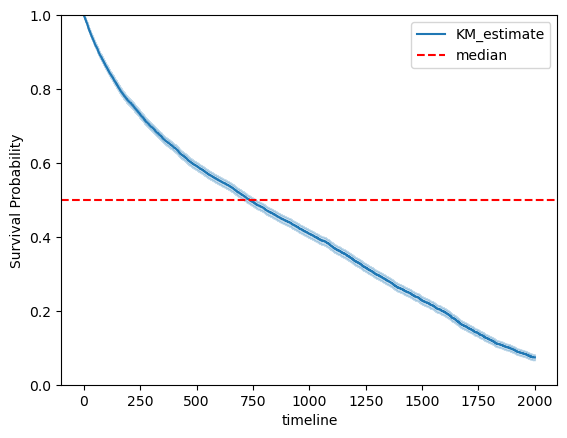

In [5]:
from lifelines import KaplanMeierFitter

km = KaplanMeierFitter()
km.fit(
    durations=y["duration"],
    event_observed=y["event"],
)
ax = km.plot_survival_function()
ax.axhline(y=0.5, linestyle="--", color="r", label="median")
ax.set_ylabel("Survival Probability")
ax.set_ylim(0, 1)
ax.legend()

Since we have censored data, $\hat{S}(t)$ doesn't reach 0 within our
observation window. We would need to extend the observation window to
estimate the survival function beyond this limit. The **Kaplan-Meier
estimator does not attempt the extrapolate beyond the last observed event**.


We can read the median time to event directly from this curve: it is the time
at the intersection of the estimate of the survival curve with the horizontal
line for a 50% probability of failure.

Let's use the `scipy` library to compute this value by using interpolation to inverse
the survival function (from probability to time):

In [6]:
from scipy.interpolate import interp1d

time_to_quantile_level = interp1d(
    km.survival_function_["KM_estimate"], km.survival_function_.index
)
time_to_quantile_level(0.5).round(1)

np.float64(734.2)


This empirically confirms that the median time to event estimated by the
Kaplan-Meier estimator applied to the censored observations is very close to
the ground-truth median time to event measured directly on the uncensored
synthetic data.


### 2.2 Kaplan-Meier estimation on subgroups derived from `X`

We can enrich our analysis by introducing covariates, that are statistically
associated to the events and durations.

In [7]:
file_url = DATA_URL + "truck_failure_10k_features.parquet"
X = pd.read_parquet(fetch_file(file_url, folder="truck_dataset"))
df = X.join(y)
df

,driver_skill,brand,truck_model,usage_rate,event,duration
0,0.6,Cheapz,C3,0.80,True,980.394661
1,0.8,Robusta,RA,0.50,True,1207.870100
2,0.7,Robusta,RB,0.55,False,125.000000
3,0.6,Cheapz,C3,0.31,True,96.839004
4,0.5,Cheapz,C1,0.75,True,88.077852
...,...,...,...,...,...,...
9995,0.6,Robusta,RA,0.76,True,0.435731
9996,0.5,Robusta,RB,0.75,True,356.591211
9997,0.8,Cheapz,C2,0.64,True,847.951259
9998,0.2,Cheapz,C1,0.63,True,25.551167


Let's stratify using the brand variable:

(0.0, 1.0)

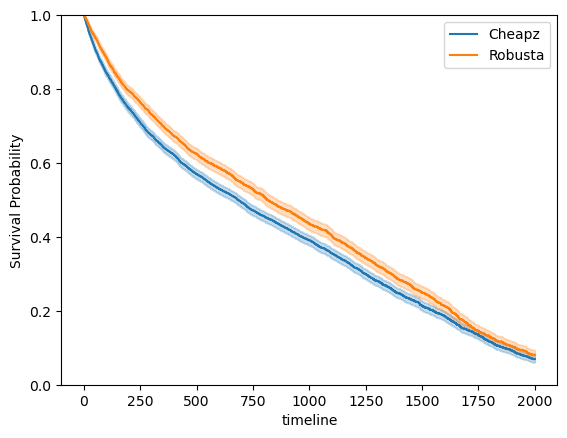

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
for brand_name, group in df.groupby("brand"):
    (
        KaplanMeierFitter()
        .fit(
            durations=group["duration"],
            event_observed=group["event"],
        )
        .plot_survival_function(ax=ax, label=brand_name)
    )
ax.set_ylabel("Survival Probability")
ax.set_ylim(0, 1)


### 2.3 Model evaluation

The Brier score and the C-index are measures that **assess the quality of a predicted
survival curve** on a finite data sample.

#### Integrated Brier Score (IBS)

The **[time-dependent Brier
score](https://soda-inria.github.io/hazardous/generated/hazardous.metrics.brier_score_survival.html)
is a proper scoring rule**, meaning that an estimate of the survival
probability at a given time horizon has minimal Brier score if and only if it
matches the true survival probability induced by the underlying data
generating process. In that respect the **Brier score** assesses both the
**calibration** and the **ranking power** of a survival probability
estimator.

It is comprised between 0 and 1 (lower is better). It answers the question
"how close to the real probabilities are our predictions?".

<figure>
<img src="assets/BrierScore.svg" style="width:80%">
</figure>

The **[Integrated Brier
Score](https://soda-inria.github.io/hazardous/generated/hazardous.metrics.integrated_brier_score_survival.html)**
(IBS) is the average of the time-dependent Brier score over a time horizon
$[t_{min}, t_{max}]$. The IBS is a proper scoring rule for the estimation of
the survival function (i.e. the survival probability at any given time
horizon).

The **IBS values** are comprised **between 0 and 1**, and **lower is better**.

#### Concordance-Index (C-index)

The **C-index** only assesses the **ranking power**: it is invariant to a monotonic
transform of the survival probabilities. It only focus on the ability of a predictive
survival model to identify which individual is likely to fail first out of any pair of
two individuals.

It answers the question: "given two individuals, how likely are we to predict
in the correct order that one has experienced the event before the other?"

Conceptually, it is quite similar to the Kendall's Tau coefficient or the ROC
AUC. **C-index values** are comprised **between 0 and 1** and **higher is
better**, where 1 means perfect ranking and 0.5 is equivalent to a random
ranking or constant ranking (irrespective of the information available in
$X$).

Let's put this in practice. In the following, we use the KM estimated
survival for all individuals in the datasets, irrespective of the value of the
covariates $X$:

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
km = KaplanMeierFitter().fit(
    durations=y_train["duration"],
    event_observed=y_train["event"],
)

observed_times = y_train.loc[y_train["event"]]["duration"]
time_grid = np.quantile(observed_times, np.linspace(0, 1, 30))
y_pred_km = km.survival_function_at_times(time_grid).values

y_pred_km = np.repeat(y_pred_km[None, :], y_test.shape[0], axis=0)
y_pred_km.shape

(2500, 30)

/Users/ogrisel/miniforge3/envs/dev/lib/python3.13/site-packages/hazardous/metrics/_concordance_index.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_test_tau.loc[y_test_tau["duration"] > tau, "event"] = 0


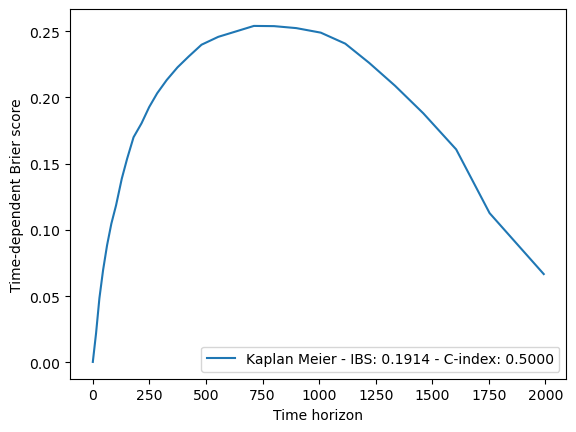

In [10]:
from hazardous.metrics import (
    concordance_index_incidence,
    brier_score_survival,
    integrated_brier_score_survival,
)


class Scorer:
    def __init__(self):
        self.brier_scores = dict()
        self.ibs = dict()
        self.c_index = dict()

    def __call__(self, model_name, y_train, y_test, y_pred, time_grid):
        self.brier_scores[model_name] = brier_score_survival(
            y_train, y_test, y_pred, time_grid
        )
        self.ibs[model_name] = float(
            integrated_brier_score_survival(y_train, y_test, y_pred, time_grid).item()
        )
        self.c_index[model_name] = float(
            concordance_index_incidence(
                y_test, 1 - y_pred, y_train, time_grid=time_grid
            ).item()
        )

        _, ax = plt.subplots()
        for name, brier_score in self.brier_scores.items():
            label = (
                f"{name} - IBS: {self.ibs[name]:.4f}"
                f" - C-index: {self.c_index[name]:.4f}"
            )
            ax.plot(time_grid, brier_score, label=label)
        ax.set_ylabel("Time-dependent Brier score")
        ax.set_xlabel("Time horizon")
        ax.legend()


scorer = Scorer()
scorer("Kaplan Meier", y_train, y_test, y_pred_km, time_grid)


We observe that the prediction quality of the KM estimate assessed by the
time-dependent Brier score is worst for time horizons between 200 and 1500
days after the beginning of the observation period.

Additionally, we compute the Integrated Brier Score (IBS) which we will use
to summarize the time-dependent Brier score curve and compare the quality of
different estimators of the survival curve on the same test set: $$IBS =
\frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} BS(t) dt$$

We also compute the C-index to assess the ranking power of our survival
probability estimator: here it is exactly 0.5, which means that the estimator
equivalent to a random prediction of which individuals are more likely to
experience the event first. Indeed, the Kaplan-Meier estimator is a
unconditional or marginal estimator: it can't be used to rank individuals
predictions as it predicts the same survival curve for any row in `X_test`.

In the following, we will see how to use the information in `X` to improve
upon this baseline by fitting conditional survival models.

### 2.4 Cox Proportional Hazards

The hazard rate $\lambda(t)$ represents the "speed of failure" or **the
probability that an event occurs in the next $dt$, given that it hasn't
occurred yet**. This can be written as:

$$\begin{align} \lambda(t) &=\lim_{dt\rightarrow 0}\frac{P(t \leq T^* < t + dt
| P(T
\geq t))}{dt} \\
&= \lim_{dt\rightarrow 0}\frac{P(t \leq T^* < t + dt)}{dtS(t)} \\
&= \frac{f(t)}{S(t)} \end{align} $$

The Cox PH model is the most popular way of dealing with covariates $X$ in
survival analysis. It computes a log linear regression on the target $T =
\min(T^*, C)$, and consists in a baseline term $\lambda_0(t)$ and a covariate
term with weights $\beta$. $$\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top
\beta)$$

Note that only the baseline depends on the time $t$, but we can extend Cox PH
to time-dependent covariate $x_i(t)$ and time-dependent weights $\beta(t)$.
We won't cover these extensions in this tutorial.

This methods is called ***proportional*** hazards, since for two different
covariate vectors $x_i$ and $x_j$, their ratio is: $$\frac{\lambda(t,
x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t)
e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$$

This ratio is not dependent on time, and therefore the hazards are
proportional.

Let's run it on our truck-driver dataset using the implementation of
`lifelines`. This models requires preprocessing of the categorical features
using One-Hot encoding. Let's use the scikit-learn column-transformer to
combine the various components of the model as a pipeline:

In [11]:
from skrub import TableVectorizer
from lifelines.fitters.coxph_fitter import CoxPHFitter

df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

vectorizer = TableVectorizer()
df_train = vectorizer.fit_transform(df_train)
df_test = vectorizer.transform(df_test)
df_train

,driver_skill,brand_Robusta,truck_model_C1,truck_model_C2,truck_model_C3,truck_model_RA,truck_model_RB,usage_rate,event,duration
2967,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.42,0.0,1759.000000
700,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.54,1.0,270.680206
3481,0.3,1.0,0.0,0.0,0.0,0.0,1.0,0.82,0.0,106.000000
1621,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.80,1.0,971.871277
800,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.84,1.0,31.215118
...,...,...,...,...,...,...,...,...,...,...
9225,0.2,1.0,0.0,0.0,0.0,1.0,0.0,0.50,1.0,835.325073
4859,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.45,1.0,1288.826294
3264,0.3,0.0,0.0,0.0,1.0,0.0,0.0,0.80,1.0,1014.666504
9845,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.77,1.0,922.165222


In [12]:
cox = CoxPHFitter(penalizer=1e-2).fit(
    df_train, duration_col="duration", event_col="event"
)
y_pred_cox = cox.predict_survival_function(df_test, times=time_grid).to_numpy().T
y_pred_cox.shape

(2500, 30)

/Users/ogrisel/miniforge3/envs/dev/lib/python3.13/site-packages/hazardous/metrics/_concordance_index.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_test_tau.loc[y_test_tau["duration"] > tau, "event"] = 0


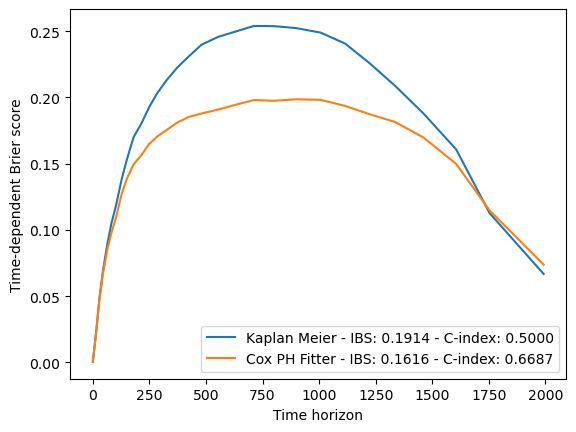

In [13]:
scorer("Cox PH Fitter", y_train, y_test, y_pred_cox, time_grid)


So the Cox Proportional Hazard model from lifelines fitted as a simple pipeline
with one-hot encoded categorical variables and raw numerical variables seems already
significantly better than our unconditional baseline.

Let's now display the survival curves of the first 5 trucks-driver pairs.

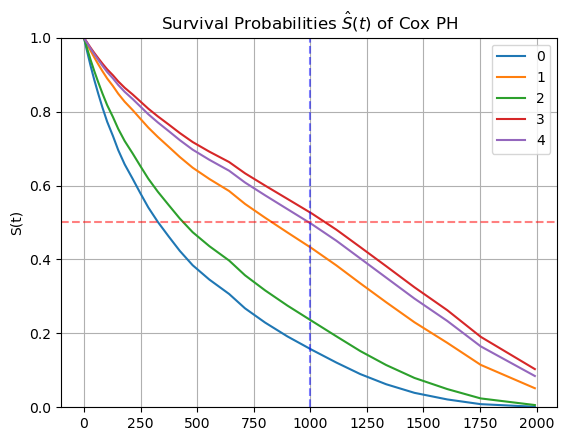

In [14]:
def plot_survival_curves(y_pred, time_grid, n_curves=5):
    _, ax = plt.subplots()
    for idx in range(n_curves):
        ax.plot(time_grid, y_pred[idx], label=str(idx))
    ax.set_ylim(0, 1)
    ax.set_ylabel("S(t)")
    ax.set_title(r"Survival Probabilities $\hat{S}(t)$ of Cox PH")
    ax.axhline(y=0.5, linestyle="--", color="r", alpha=0.5)
    ax.axvline(x=1000, linestyle="--", color="b", alpha=0.5)
    ax.legend()
    ax.grid()


plot_survival_curves(y_pred_cox, time_grid)


We see that predicted survival functions can vary significantly for different
individuals in the test set.

There are two ways to read this plot:

First we could consider our **predictive survival analysis model as a probabilistic
regressor**: if we want to **consider a specific probability of survival, say 50%**,
we can mentally draw an horizontal line at 0.5, and see that:

- test data point `#0` has an estimated median survival time around 300 days,
- test data point `#1` has an estimated median survival time around 800 days,
- test data point `#2` has an estimated median survival time around 450 days...

Secondly we could also consider our **predictive survival analysis model as a
probabilistic binary classifier**: if we **consider a specific time horizon, say 1000
days**, we can see that:

- test data point `#0` has less than a 20% chance to remain event-free at day 1000,
- test date point `#3` has around a 50% chance to remain event-free at day 1000...

Let's get some intuition about the features importance by inspecting the
coefficients of the Cox model:

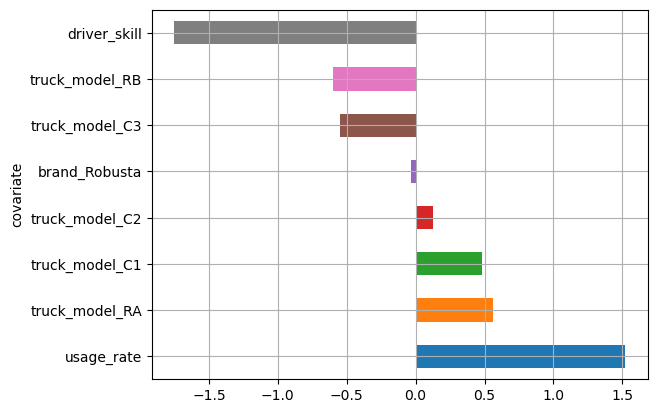

In [15]:
import matplotlib as mpl

_ = np.log(cox.hazard_ratios_.sort_values(ascending=False)).plot.barh(
    facecolor=mpl.color_sequences["tab10"], grid=True
)


We observe that the most important features are `usage_rate` and
`driver_skill`: the higher the usage rate, the higher the hazard of
experiencing an event. The higher the driver skill, the lower the hazard of
experiencing an event.


### 2.5 SurvivalBoost

We now introduce a novel survival estimator named
[`SurvivalBoost`](https://soda-inria.github.io/hazardous/generated/hazardous.SurvivalBoost.html),
based on sklearn's
[`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html).
It can estimate cause-specific cumulative incidence functions in a competing risks
setting, by minimizing a cause specific proper scoring rule objective.

We recently published a [paper](https://arxiv.org/abs/2410.16765) detailing
the Survival Boost model at the AISTATS 2025 conference.

/Users/ogrisel/code/scikit-learn/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/Users/ogrisel/miniforge3/envs/dev/lib/python3.13/site-packages/hazardous/metrics/_concordance_index.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_test_tau.loc[y_test_tau["duration"] > tau, "event"] = 0


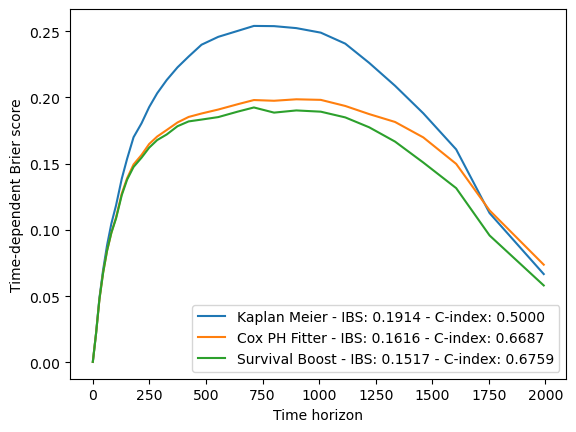

In [16]:
from hazardous import SurvivalBoost
from sklearn.preprocessing import OrdinalEncoder


vectorizer = TableVectorizer(high_cardinality=OrdinalEncoder())
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

surv_boost = SurvivalBoost(show_progressbar=False).fit(X_train_trans, y_train)
y_pred_survboost = surv_boost.predict_survival_function(X_test_trans, time_grid)

scorer("Survival Boost", y_train, y_test, y_pred_survboost, time_grid)


SurvivalBoost gives great performance on the Brier Score, however C-index is
slightly under the log-linear model for this dataset.

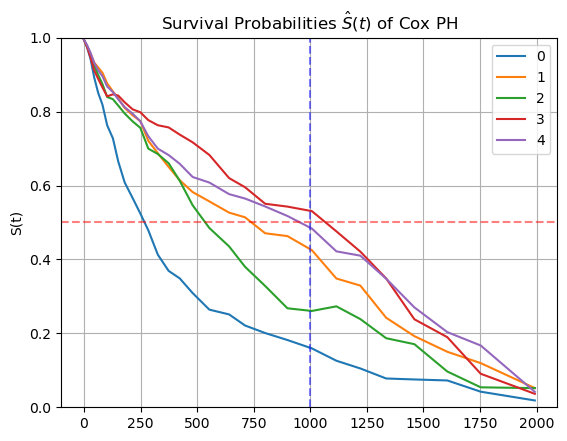

In [17]:
plot_survival_curves(y_pred_survboost, time_grid)


We also notice that curves are **not** subject to the proportional hazards
constraint: contrary to the curves predicted by the previous Cox PH model,
the curves predicted by Survival Boost can cross each other.

Since we use a scikit-learn estimator under the hood, Survival Boost is
compatible with scikit-learn machinery. Below we show how to determine global
feature importance via permutation importance, and analyse them via partial
dependency plot.

<Axes: >

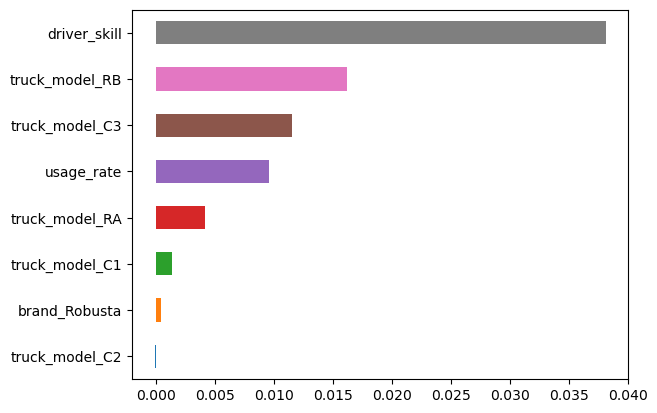

In [18]:
from sklearn.inspection import permutation_importance


permutations = permutation_importance(surv_boost, X_test_trans, y_test)

(
    pd.Series(permutations["importances_mean"], index=X_test_trans.columns)
    .sort_values(ascending=True)
    .plot.barh(facecolor=mpl.color_sequences["tab10"])
)

<Figure size 1200x600 with 0 Axes>

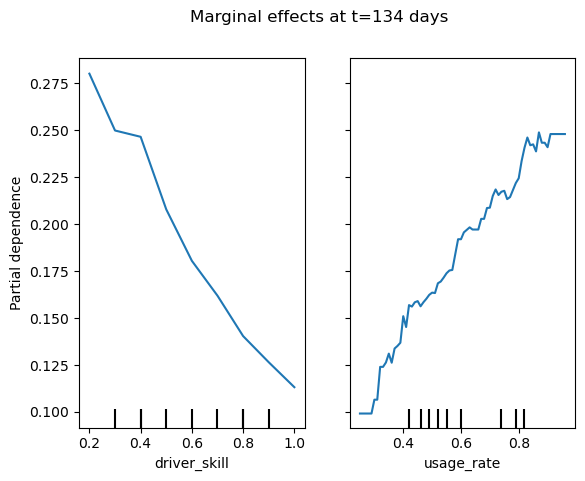

<Figure size 800x800 with 0 Axes>

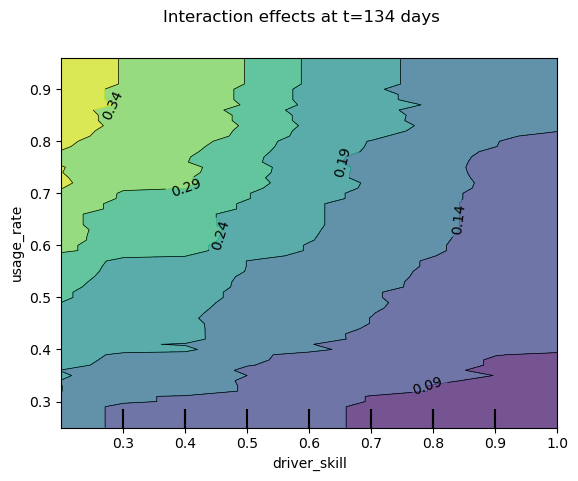

<Figure size 1200x600 with 0 Axes>

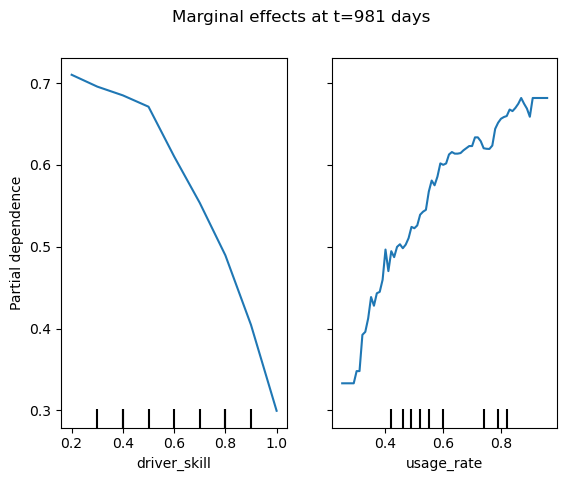

<Figure size 800x800 with 0 Axes>

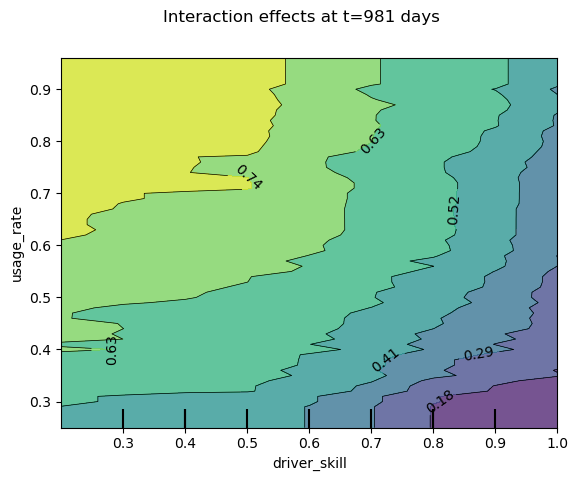

In [19]:
from sklearn.inspection import PartialDependenceDisplay

for percentile in [0.25, 0.75]:
    horizon = np.quantile(observed_times, percentile)
    t = np.full(shape=X_test_trans.shape[0], fill_value=horizon)
    X_test_trans_at_t = pd.concat(
        [
            pd.DataFrame(dict(t=t)),
            X_test_trans.reset_index(drop=True),
        ],
        axis="columns",
    )
    plt.figure(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        surv_boost.estimator_,
        X_test_trans_at_t.to_numpy(),
        response_method="predict_proba",
        method="brute",
        features=["driver_skill", "usage_rate"],
        feature_names=X_test_trans_at_t.columns,
    )
    _ = plt.suptitle(f"Marginal effects at t={horizon:.0f} days")

    plt.figure(figsize=(8, 8))
    PartialDependenceDisplay.from_estimator(
        surv_boost.estimator_,
        X_test_trans_at_t.to_numpy(),
        response_method="predict_proba",
        method="brute",
        features=[("driver_skill", "usage_rate")],
        feature_names=X_test_trans_at_t.columns,
    )
    _ = plt.suptitle(f"Interaction effects at t={horizon:.0f} days")


## 3. Discussion and limits

There are some tradeoffs to consider when thinking about framing a survival
analysis problem.

### Types of censoring

Note that we can often distinguish between two types of censoring:

1. Censoring during the study (in-study censoring)
2. Censoring at the end of the study (administrative censoring)

<figure>
<img src="assets/censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

- In clinical studies, **in-study censoring** refers to patients we lost
  track of, (e.g., they moved out of town for a reason unrelated to the event
  of interest). **Administrative censoring** refers to the end of the study.
- In churn analysis, **churned users** correspond to those who have
  experienced the event, while remaining users are those who have survived up
  to the present day. Administrative censoring naturally corresponds to the
  present date, with all active users having survived. In-study censoring is
  not necessarily present in churn analysis.

### Competing risks vs censoring

Note that some events can be **competing risks**. For instance, in a clinical
context, patients can die from different causes: cancer, cardiovascular
disease, road accidents, etc. In this case, we can model the time to event as
a **multiclass classification problem** with a different class for each
cause. If we are interested studying the effect of a drug on a particular
cause of death (e.g. cancer), it is important not to treat the other causes
of death as censored observations, since they increasing the observation
window would not make those deaths magically disappear.

We therefore need specialized models and evaluation metrics to deal with
competing risks. The `hazardous` library provides built-in support for for
this setting in addition to the standard survival analysis methods (with
binary events).

Telling which event is a competing risk and which one is a case of in-study
censoring is not always easy. For instance, an individual leaving the study
because they moved to another country is a case of in-study censoring. We had
the capacity to continue tracking them, we could still have observed the
event of interest (for instance, dying of cancer). However, in the churning
analysis setting, an individual unsubscribing from a service because they
moved to another country where the service is not available would better be
modeled as a competing risk to the event of interest (e.g. unsubscribing
because of loss of interest in the service). However, sometimes we don't know
the reason why an individual unsubscribed, and we have to collapse different
kinds of events together.

### Survival analysis vs classification

In general terms, it's beneficial to use survival analysis methods whenever
you have a significant amount of **right-censored observations** with
censoring times lower than the maximum prediction horizon of interest.

If your application of interest has a focus on a specific time horizon and
that this time horizon is short compared to the average observation window,
it is likely that that the fraction of censored data points with a censoring
time lower than that horizon is very small.

For instance, in a predictive maintenance setting for a datacenter, you might
be interested in the probability of failure of hard drives in a given node
**in the coming hour** to route traffic to a backup node and avoid
disruption. Assuming nodes operates on average for tens of thousands of hours
before failure, truncating the dataset to remove all the data points related
to the operations of nodes in the past hour (administrative censoring) would
not be a problem. We can treat this problem as a binary classification
problem without any need for correcting the bias introduced by the censoring,
neither for training nor for evaluation.

In other cases, the time horizon of interest can be very long compared to the
average observation window and as a result, the fraction of censored data
points with a censoring time lower than that horizon is very large. In this
case, treating the problem as a binary classification problem would introduce
a large bias, both in training and evaluation. For those cases, dedicated
survival analysis training and evaluation methods are necessary to avoid this
bias.

<img src="assets/survival_vs_classification.png">

### Dealing with time-varying features

The lack of support for time-varying features is a major limitation of the
survival analysis implementations presented in this tutorial. While it is
possible to such support by adapting the model training scheme or by using
preprocessing, it is not doable out-of-the box, and more research on
evaluation is necessary before including generic tools into the hazardous
library.

The methods presented in this tutorial limit only feature values available at
the beginning of the study. In the context of modeling time to accident for
an insurance company, this could be the information about the driver at the
beginning of the insurance contract for instance.

However, in many applications, the features are time-varying and ignoring
more recent information can lead to severely degraded predictive performance.

A common way to deal with this is to use **landmarking**. This consists in
creating a new dataset (both for training and evaluation) with a fixed number
of times of observation per individual. For each individual and each landmark
time, compute the features available at that landmark time, and also adapt
the target to measure the time-to-event (or censoring) relative to the
landmark time. Then proceed with the training and evaluation as usual.

<img src="assets/time_varying_features.png" style="width:100%">

This method raises the question about discrepancy between the training
distribution and the actual distribution at inference time.